## To Do
- Prevent/improve handling of duplicates

In [116]:
from pathlib import Path
import gc

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, GroupKFold #train_test_split, RepeatedKFold
from sklearn.linear_model import Ridge #, RidgeCV
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from custom.preprocessing import (
    preserve_geometry,
    _add_shrug_to_mosaiks,
    _merge_mosaiks_and_secc,
)
from custom.shrug_data import (
    load_shrug_shapefiles,
    load_shrug_secc,
    change_shapefile_IDs_to_int,
)
from custom.evaluation import show_results, plot_prediction_maps, plot_precision_recall_curve
from custom.utils import load_gdf, latlon_df_to_gdf

In [2]:
ROOT = Path.cwd().parent
DATA_ROOT = ROOT / "data"

## Load and merge data

### Mosaiks features (with Lat-Lon Coords)

Old API data

In [3]:
# using old data downloaded from the online API
# data_label = "old_v4000"
# filename = "mosaiks_downloaded_old_features_rounded.csv"

# # Load data
# mosaiks_features = pd.read_csv(mosaiks_path+filename)

2013 data

In [4]:
filename = '2013_exact_2400m_v4000_L8_0_to_96166.parquet.gzip'

# Load data
mosaiks_features = pd.read_parquet(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename)
mosaiks_features_gdf = latlon_df_to_gdf(mosaiks_features)
print("No. points:", mosaiks_features_gdf.shape[0])

mosaiks_features_gdf = mosaiks_features_gdf.dropna()
print("No. points after dropping NAs:", mosaiks_features_gdf.shape[0])

No. points: 96167
No. points after dropping NAs: 89677


In [5]:
# INVESTIGATE THIS! For some reason there are 2 duplicate rows in this loaded data.
# RESOLVED: This is due to .sjoin in the mosaiks_points.py script - fixed. New coordinates must be generated and requested.
filter = mosaiks_features_gdf.duplicated(subset=["Lat","Lon"], keep="first")
mosaiks_features_gdf = mosaiks_features_gdf[~filter]

2021 data

In [8]:
# data_label_21 = "2021_2400km_v4000"
filename_21 = '2021_exact_2400m_v4000_L8_0_to_96166.parquet.gzip'

# Load data
mosaiks_features_21 = pd.read_parquet(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename_21)
mosaiks_features_gdf_21 = latlon_df_to_gdf(mosaiks_features_21)
print("No. points:", mosaiks_features_gdf_21.shape[0])

mosaiks_features_gdf_21 = mosaiks_features_gdf_21.dropna()
print("No. points after dropping NAs:", mosaiks_features_gdf_21.shape[0])

No. points: 96167
No. points after dropping NAs: 88688


In [9]:
# TEMPORARY FIX for duplicate rows
filter = mosaiks_features_gdf_21.duplicated(subset=["Lat","Lon"], keep="first")
mosaiks_features_gdf_21 = mosaiks_features_gdf_21[~filter]

### SHRUG Villages (geometries + populations + SECC)

Get shrug keys (pre-merged with shapes)

In [10]:
shrug_village = load_gdf(
    "01_preprocessed/SHRUG/shrug_pc11r_keys_with_shapes",
    "shrug_pc11r_keys_with_shapes.shp",
)
shrug_village = preserve_geometry(shrug_village, suffix="village")

In [10]:
### DUPLICATES ISSUE ###
# There are 9,000 duplicate rows in the SHRUG data... Drop them for now.
shrug_village.drop_duplicates(subset=["shrid"], inplace=True)

Add population data from the main SHRUG dataset

In [13]:
shrug_pc11 = pd.read_csv(DATA_ROOT / "00_raw/SHRUG/shrug-v1.5.samosa-pop-econ-census-csv/shrug_pc11.csv")
shrug_village_pop = pd.merge(
    shrug_village, 
    shrug_pc11[["shrid", "pc11_pca_tot_p_r"]],
    on="shrid",
    how="inner",
)

Add rural poverty from SECC data

In [14]:
shrug_secc = load_shrug_secc()
shrug_village_pop_secc = pd.merge(
    shrug_village_pop, 
    shrug_secc[["shrid", "secc_pov_rate_rural"]], 
    on="shrid", 
    how="inner"
)

Clean up and show

In [15]:
ordered_col_names = [
    'shrid',
    'pc11_s_id', 'pc11_d_id', 'pc11_sd_id', 'pc11_tv_id', 'tv_name',
    'geometry', 'geometry_village',
    'pc11_pca_tot_p_r', 'secc_pov_rate_rural'
    ]
shrug_village_pop_secc = shrug_village_pop_secc[ordered_col_names]

In [16]:
shrug_village_pop_secc.head()

,shrid,pc11_s_id,pc11_d_id,pc11_sd_id,pc11_tv_id,tv_name,geometry,geometry_village,pc11_pca_tot_p_r,secc_pov_rate_rural
0,11-01-000002,1,1,1,2,Keran,"POLYGON ((73.96017 34.64970, 73.96121 34.65066...","POLYGON ((73.96017 34.64970, 73.96121 34.65066...",3770.0,0.477891
1,11-01-000005,1,1,1,5,Mindiyan,"POLYGON ((74.05823 34.65639, 74.05905 34.65657...","POLYGON ((74.05823 34.65639, 74.05905 34.65657...",5255.0,0.776421
2,11-01-000006,1,1,1,6,Patrin,"POLYGON ((74.08185 34.63302, 74.08281 34.63415...","POLYGON ((74.08185 34.63302, 74.08281 34.63415...",3001.0,0.730325
3,11-01-000007,1,1,1,7,Juma Gund,"POLYGON ((74.12266 34.63367, 74.12290 34.63407...","POLYGON ((74.12266 34.63367, 74.12290 34.63407...",1310.0,0.530650
4,11-01-000009,1,1,1,9,Har Duing,"POLYGON ((74.25775 34.66372, 74.25932 34.66531...","POLYGON ((74.25775 34.66372, 74.25932 34.66531...",3080.0,0.681202


### SHRUG Blocks (Group SHRUG Villages)

Take weighted average of village poverty rates by population within subdistricts:

In [17]:
shrug_village_pop_secc["rate_times_pop"] = shrug_village_pop_secc["secc_pov_rate_rural"] * shrug_village_pop_secc["pc11_pca_tot_p_r"]
shrug_block_pop_secc = shrug_village_pop_secc.groupby(['pc11_s_id', 'pc11_d_id', 'pc11_sd_id',]).agg(
    n_shrids=("shrid", "count"), 
    sd_tot_p_r=("pc11_pca_tot_p_r", "sum"),
    rate_times_pop_sum=("rate_times_pop", "sum")
).reset_index()
shrug_block_pop_secc["secc_pov_rate_rural_subdistrict"] = shrug_block_pop_secc["rate_times_pop_sum"]/shrug_block_pop_secc["sd_tot_p_r"]

shrug_village_pop_secc.drop(columns=["rate_times_pop"], inplace=True)
shrug_block_pop_secc.drop(columns=["rate_times_pop_sum"], inplace=True)

Load and add subdistrict shapes

In [18]:
shrug_sd_shapes = load_gdf(
    "00_raw/SHRUG/geometries_shrug-v1.5.samosa-open-polygons-shp",
    "subdistrict.shp",
)
shrug_sd_shapes = change_shapefile_IDs_to_int(shrug_sd_shapes)

shrug_block_pop_secc = pd.merge(
    shrug_block_pop_secc,
    shrug_sd_shapes,
    on=["pc11_s_id", "pc11_d_id", "pc11_sd_id"],
    how="inner",
)
shrug_block_pop_secc = preserve_geometry(shrug_block_pop_secc, suffix="subdistrict")
shrug_block_pop_secc = gpd.GeoDataFrame(shrug_block_pop_secc)

In [19]:
shrug_block_pop_secc.head()

,pc11_s_id,pc11_d_id,pc11_sd_id,n_shrids,sd_tot_p_r,secc_pov_rate_rural_subdistrict,sd_name,geometry,geometry_subdistrict
0,1,1,1,112,445000.0,0.525771,Kupwara,"POLYGON ((74.50665 34.51685, 74.50441 34.51444...","POLYGON ((74.50665 34.51685, 74.50441 34.51444..."
1,1,1,2,187,247680.0,0.358365,Handwara,"POLYGON ((74.20004 34.51438, 74.20023 34.51437...","POLYGON ((74.20004 34.51438, 74.20023 34.51437..."
2,1,1,3,39,44591.0,0.336099,Karnah,"POLYGON ((73.90129 34.44379, 73.90364 34.44372...","POLYGON ((73.90129 34.44379, 73.90364 34.44372..."
3,1,2,4,48,64972.0,0.387685,Khag,"POLYGON ((74.52723 34.04333, 74.52686 34.04173...","POLYGON ((74.52723 34.04333, 74.52686 34.04173..."
4,1,2,5,102,149671.0,0.560799,Beerwah,"POLYGON ((74.66784 34.11153, 74.66878 34.11123...","POLYGON ((74.66784 34.11153, 74.66878 34.11123..."


### Merge Mosaiks featues and SECC target via shapes

Village-level

In [20]:
mosaiks_shrug_village_rates_gdf = _add_shrug_to_mosaiks(mosaiks_features_gdf, shrug_village_pop_secc)

Block-level

In [21]:
mosaiks_shrug_block_rates_gdf = _add_shrug_to_mosaiks(mosaiks_features_gdf, shrug_block_pop_secc)

In [22]:
# del shrug_village
# del shrug_village_pop
# del shrug_village_pop_secc
# del shrug_block_pop_secc
# del shrug_sd_shapes

# del shrug_secc
# del shrug_pc11
# del mosaiks_features
# del mosaiks_features_gdf
# gc.collect()

## Select data for modelling

Choose data to use for modelling

In [23]:
# Set label to use for plot titles and filenames of experiment results
data_label = "2013_2400m_v4000"

In [24]:
# # [VILLAGE] Select dataset and target
gdf = mosaiks_shrug_village_rates_gdf
y_name = "secc_pov_rate_rural"

In [25]:
# # [BLOCK] Select dataset and target
# gdf = mosaiks_shrug_block_rates_gdf
# y_name = "secc_pov_rate_rural_subdistrict"
# data_label = data_label + "_SD_LABELS"

In [26]:
# drop rows with unavailable target
gdf_clean = gdf.dropna(subset=y_name)
# drop rows with duplicated indices
filter = gdf_clean.index.duplicated(keep='first')
print("Rows with duplicated indices:", filter.sum())
gdf_clean = gdf_clean[~filter]

Rows with duplicated indices: 1


In [27]:
# select features and target
NUM_FEATURES = 4000
mosaiks_column_names = [str(i) for i in range(NUM_FEATURES)]

X = gdf_clean[mosaiks_column_names]
y = gdf_clean[y_name]

Grouped train-test split: making sure that datapoints from the same village don't get split across train and test datasets (to avoid leakage).

Can change grouping variable to larger scale if needed (e.g. unique subdistrict IDs, etc)

In [28]:
# choose train/test indices
grouping_var = "pc11_tv_id" #"pc11_sd_id"
splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=0)
split = splitter.split(gdf_clean, groups=gdf_clean[grouping_var])
train_index_position, test_index_position = list(split)[0]

# convert to true pandas indices
train_index = gdf_clean.index[train_index_position]
test_index = gdf_clean.index[test_index_position]

In [29]:
# only keep test indices that also appear in the 2021 data (for comparison later)
test_index_common = np.intersect1d(test_index, mosaiks_features_gdf_21.index)
print("No. test points 2013:", len(test_index))
print("Common test points:", len(test_index_common))

No. test points 2013: 25036
Common test points: 23774


In [30]:
# split data into train and test
X_train, X_test, y_train, y_test = (
    X.loc[train_index],
    X.loc[test_index_common],
    y.loc[train_index],
    y.loc[test_index_common],
)
# select 2021 test data
X_test_21 = mosaiks_features_gdf_21.loc[test_index_common].drop(["Lat", "Lon", "geometry"], axis=1)

## Modelling
Datapoints = latlong points

### Train model

In [31]:
model = Ridge()
model.fit(X_train, y_train) #, sample_weight=y_train

Ridge()

- target distribution
- optimise model

In [32]:
# # or with parameter search (grouped k-fold)

# group_kfold = GroupKFold(n_splits=5)
# cv_grouped = group_kfold.split(X, y, gdf_clean[grouping_var])

# model = RidgeCV(alphas=[0.01, 1, 10], cv=cv_grouped)
# model.fit(X_train, y_train, sample_weight=y_train)

# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)

### Test

Next, we use the trained model to make predictions in the test set.

In [85]:
y_pred = model.predict(X_test)

In [86]:
y_pred_21 = model.predict(X_test_21)

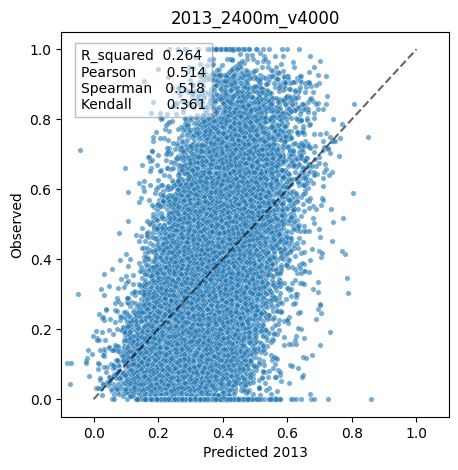

In [87]:
show_results(y_test, y_pred, file_name="scatter_"+data_label, title=data_label)

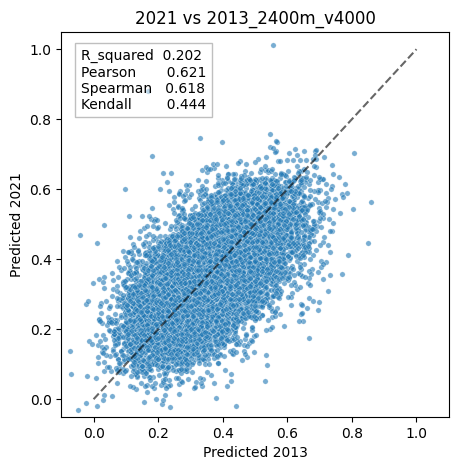

In [88]:
show_results(y_pred_21, y_pred, ylabel="Predicted 2021", file_name="2021_vs_13_scatter_"+data_label, title="2021 vs "+data_label)

In [89]:
# min, max = 0.1, 0.6
# y_pred_scaled = ((y_pred - min) / (max - min))
# y_pred_21_scaled = ((y_pred_21 - min) / (max - min))
# show_results(y_test, y_pred_scaled, file_name="scatter_scaled_"+data_label, line=False, title=data_label+" (Scaled)")

Maps

In [90]:
geo_cols = [
    "Lat", "Lon",
    "shrid",
    "pc11_s_id",
    "pc11_d_id",
    "pc11_sd_id",
    "pc11_tv_id",
    "tv_name",
    "geometry",
    "geometry_village"
    # "geometry_subdistrict",
]

In [91]:
# select dataframe with only test target and location data
gdf_clean_test_y = gdf_clean.loc[test_index_common][geo_cols + [y_name]]

# add predicted values
gdf_clean_test_y.loc[:, "predicted"] = y_pred
# gdf_clean_test_y.loc[:, "predicted_scaled"] = y_pred_scaled
gdf_clean_test_y.loc[:, "predicted_21"] = y_pred_21


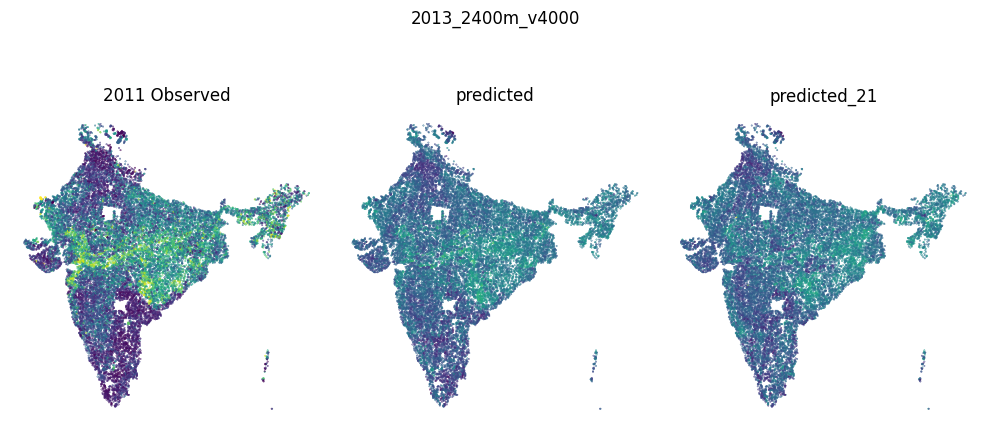

In [92]:
plot_prediction_maps(
    gdf=gdf_clean_test_y,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2021_vs_13_maps_points_"+data_label,
    title=data_label,
    )

### Aggregate to `Subdistricts`

In [93]:
print("Total test datapoints: ", gdf_clean_test_y.shape[0])

Total test datapoints:  23774


In [94]:
sd_shapes = load_shrug_shapefiles(level="subdistrict")
sd_shapes.drop(['pc11_s_id', 'pc11_d_id', 'pc11_sd_id'], axis=1, inplace=True)
sd_shapes["geometry_subdistrict"] = sd_shapes["geometry"]

In [95]:
gdf_clean_test_y_subdistricts = gdf_clean_test_y.sjoin(sd_shapes)

# change default geometry to subdistricts (for plotting)
gdf_clean_test_y_subdistricts["geometry_point"] = gdf_clean_test_y_subdistricts["geometry"]
gdf_clean_test_y_subdistricts["geometry"] = gdf_clean_test_y_subdistricts["geometry_subdistrict"]

In [96]:
subdistrict_ys = gdf_clean_test_y_subdistricts.groupby(
    [
        "pc11_s_id",
        "pc11_d_id",
        "pc11_sd_id"
    ],
    as_index=False,
)[[y_name, "predicted", "predicted_21"]].mean()
print("Datapoints with unique subdistricts: ", subdistrict_ys.shape[0])

Datapoints with unique subdistricts:  4930


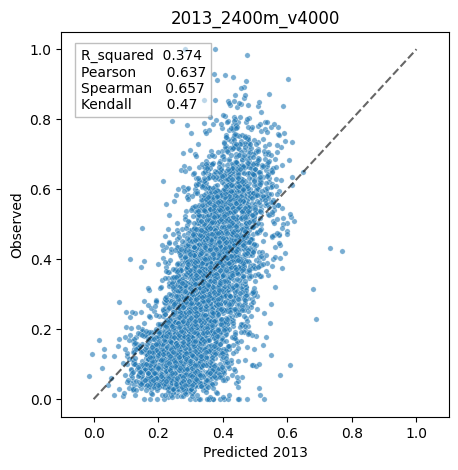

In [97]:
show_results(subdistrict_ys[y_name], subdistrict_ys["predicted"], file_name="scatter_subdistricts_"+data_label, title=data_label)

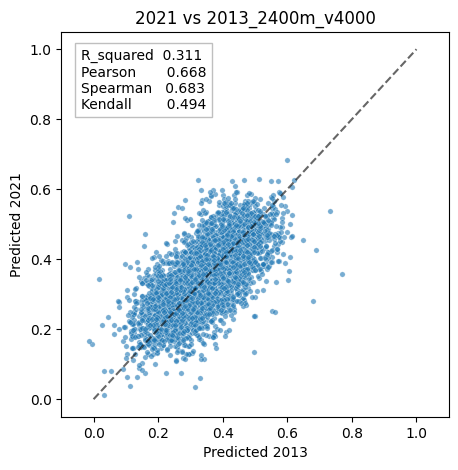

In [98]:
show_results(subdistrict_ys["predicted_21"], subdistrict_ys["predicted"], ylabel="Predicted 2021", file_name="2021_vs_13_scatter_subdistricts_"+data_label, title="2021 vs "+data_label)

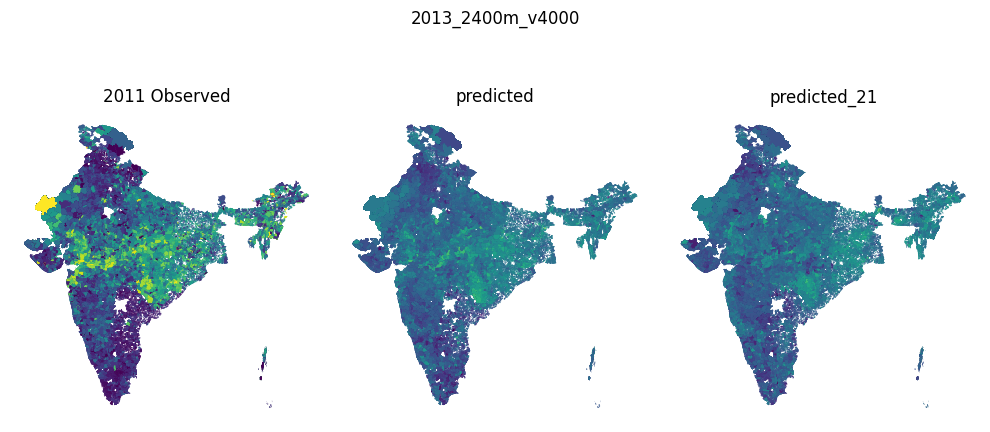

In [99]:
plot_prediction_maps(
    gdf=gdf_clean_test_y_subdistricts,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2021_vs_13_maps_subdistricts_"+data_label,
    title=data_label,
    )

## Precision-Recall Curve


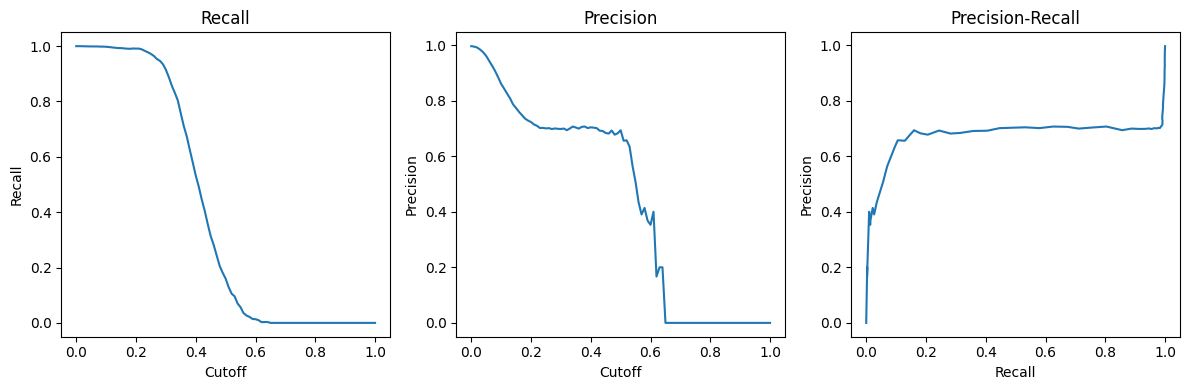

In [120]:
plot_precision_recall_curve(y_test=subdistrict_ys[y_name], y_pred=subdistrict_ys["predicted"], data_label=data_label)

# Using quintile predictions vs top quintile truth

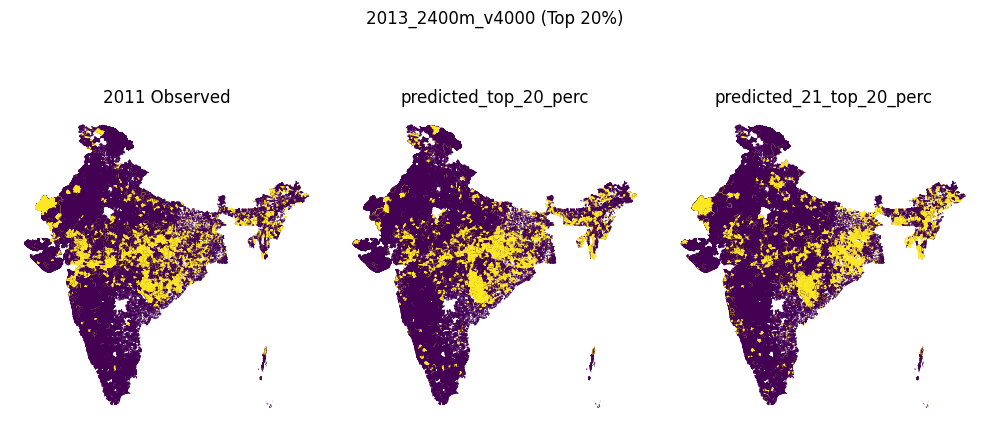

In [101]:
gdf_clean_test_y_subdistricts[y_name+"top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts[y_name], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted"], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_21_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted_21"], q=5, labels=False) == 4) * 1

plot_prediction_maps(
    gdf=gdf_clean_test_y_subdistricts,
    y_name=y_name+"top_20_perc",
    y_pred_name="predicted_top_20_perc",
    y_pred_2_name="predicted_21_top_20_perc",
    vmin=0,
    vmax=1,
    file_name="2021_vs_13_maps_sd_top20_"+data_label,
    title=data_label+" (Top 20%)",
    )

In [102]:
pred_top_quintile = np.percentile(y_pred, [80])[0]
y_pred_is_top_quintile = list(y_pred > pred_top_quintile)

pred_21_top_quintile = np.percentile(y_pred_21, [80])[0]
y_pred_21_is_top_quintile = list(y_pred_21 > pred_top_quintile)

test_top_quintile = np.percentile(y_test, [80])[0]
y_test_is_top_quintile = list(y_test > test_top_quintile)

In [103]:
precision = round(precision_score(y_test_is_top_quintile, y_pred_is_top_quintile), 3)
recall = round(recall_score(y_test_is_top_quintile, y_pred_is_top_quintile), 3)

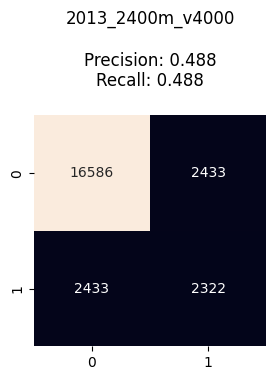

In [104]:
cm_array = confusion_matrix(y_test_is_top_quintile, y_pred_is_top_quintile)
df_cm = pd.DataFrame(cm_array, [0,1], [0,1])

plt.figure(figsize=(3,3))
sns.heatmap(df_cm, annot=True, fmt='.5g', cbar=False)
plt.title(f"{data_label}\n\nPrecision: {precision}\nRecall: {recall}\n")
plt.savefig(DATA_ROOT / "04_modeloutput" / ("confusion_matrix_"+data_label+".png"))